# Quantum Circuit Born Machine (QCBM): 
## Learning and generating Bars and Stripes patterns

QCBM is an unsupervised generative machine learning algorithm that leverages quantum circuits and Born's postulate to encode probability distributions. Before delving into the workflow of the algorithm, we will introduce the unsupervised generative learning paradigm.

### 1. Unsupervised generative learning
In contrast to supervised learning, unsupervised models only have access to datasets of inputs with no corresponding labels. Therefore, their goal is not to learn to predict the label y associated to input vectors x, or in the probability formalism the conditional probability P(y|x), but to learn the underlying probability distribution P(x) of the dataset. There are different types of unsupervised models, such as discriminative (clustering, e.g. K-means or DBSCAN), dimensionality reduction (PCA, Autoencoders, etc.), and generative (GANNs, Variational Autoencoders, Diffusion models, etc.). This tutorial focuses on generative models, where after learning P(x), the goal is to generate samples resembling the original data [1].

### 2. Algorithm
QCBM is a generative model that encodes the probability distribution of classical data as a variational quantum circuit, and it is based on Born's postulate of Quantum Mechanics, which states that the probabiliy of obtaining the bitstring x as a result of measuring the quantum state $|\psi_\theta \rangle$ is $|\langle x | \psi_\theta \rangle|^2$ [2]. In contrast to other methods such as Restricted Boltzmann machines, QCBM samples efficiently, as it just requires executing the quantum circuit. 

Regarding the training process, the variatioanl circuit is initialized with random parameters, and for each iteration it produces a specified number of samples and a loss function is evaluated, which measures the distance between the target distribution and the model distribution. The QCBM in [2] employs the squared mean discrepancy loss [3] with a Radial Basis Function (RBF) kernel [4]. Similarly to supervised QNNs, the gradient f the loss function with respect to the variational parameters can be evaluated exactly via the Parameter Shift Rule [1]. Thus, we can use gradient-based optimizers such as Adam [5] or L-BFGS-B [6]. For a more detailed explanation of the training procedure, we recommend reading [2].

After the optimal parameters are found and training is finished, we will generate samples from the circuit and analyse their validity. Apart from the precision metric, which measure the rate of generating valid patterns, there are other metrics that measure generalzation, which refers to not only considering the validity criterium but also whether the generated sample was seen in training. However, since our dataset is very small, it does not make sense to study its generalizability. For a study of QCBM generalization capabilities, read the paper [7].

### 3. The Bars and Stripes dataset
In this tutorial, we will implement a QCBM algorithm to a dataset of Bars and Stripes. This dataset is composed by binary matrices N x N that form a bar of stripe pattern. Specifically, a matrix is considered a bar if for every column, all its elements are the same. Similarly, a matrix is considered a stripe if for every row, all the elements are the same. Here we consider 3 x 3 matrices, for which there are 14 valid solutions. Thus, this 14 matrices will compose the training dataset of the QCBM.

### 4. Implementation and performance analysis


0. Connect to QAAS if you want to use Qaptiva.

In [1]:
connect = False  # Set to False if you want to run locally without QLMaaS

if connect:
    from qat.qlmaas import QLMaaSConnection
    conn = QLMaaSConnection(hostname="qlm35e.neasqc.eu", check_host=False)

1. Import the necessary libraries and the self-made QCBM class.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from myQML import QCBM

2. Define useful functions to generate the bars and stripes dataset

In [3]:
def binary_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return unpacknbits(x[:,None], num_bit).reshape((-1,)+geometry)

def unpacknbits(arr, nbit, axis=-1):
    '''unpack numbers to bitstrings.'''
    nd = np.ndim(arr)
    if axis < 0:
        axis = nd + axis
    return (((arr & (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1)))) > 0).astype('int8')

def barstripe_pdf(geometry):
    '''get bar and stripes PDF'''
    x = binary_basis(geometry)
    pl = is_bs(x)
    return pl/pl.sum()

def is_bs(samples):
    '''a sample is a bar or a stripe.'''
    return (np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2))==0\
           )|((np.abs(np.diff(samples, axis=1)).sum(axis=(1,2)))==0)

def cost(samples):
    '''Cost of a matrix, minimized when for all columns and rows, all their elements are equal'''
    return np.sum(np.minimum(np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2)), np.abs(np.diff(samples, axis=1)).sum(axis=(1,2))))/len(samples)

3. Generate the bars and stripes dataset and plot its histogram

(512, 3, 3)


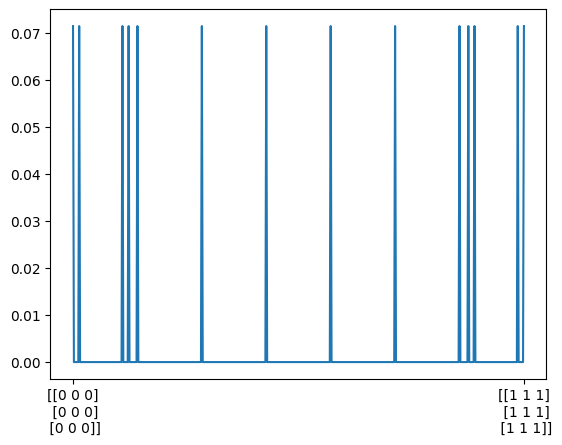

In [4]:
dimension = (3,3)
target_probs = barstripe_pdf(dimension)
plt.plot(target_probs)
# show ticks
basis = binary_basis(dimension)
print(basis.shape)
plt.xticks([0, 2**(dimension[0]*dimension[1]) - 1], [basis[0], basis[2**(dimension[0]*dimension[1]) - 1]])
plt.show = ()

4. Plot all the valid images (bars and stripes)

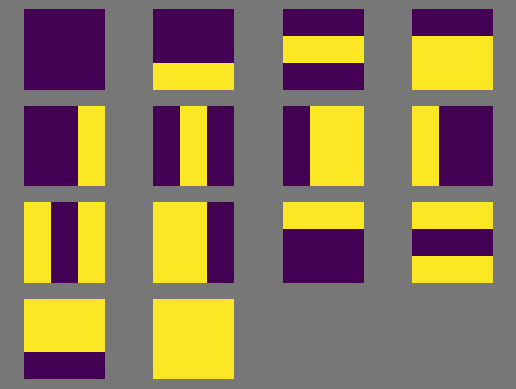

In [5]:
# generate samples
samples = basis[target_probs>1e-2]
n_sols = len(samples)

# show bar and stripes
def plot_bs(samples, size):
    plt.figure(facecolor='#777777')
    gs = plt.GridSpec(*size)

    for i in range(size[0]):
        for j in range(size[1]):
            if i*size[1]+j == len(samples): break
            plt.subplot(gs[i,j]).imshow(samples[i*size[1]+j], vmin=0, vmax=1)
            plt.axis('equal')
            plt.axis('off')
    plt.show = ()

size = (4,4)
plot_bs(samples, size)

5. Define parameters and create an object of the QCBM class

In [6]:
dimension = (3,3)
n_qubits = np.prod(dimension)
basis = binary_basis(dimension)
basis_flat = basis.reshape(basis.shape[0], -1)
n_blocks = 8
n_shots = 20000
device = 'myQLM'
sigma_list_kernel = [0.25, 0.5, 1]
method = "Adam"

qcbm = QCBM(
    n_qubits=n_qubits,
    basis=basis_flat,
    n_blocks=n_blocks, 
    n_shots=n_shots,
    device=device,
    sigma_list_kernel=sigma_list_kernel,
    dimension=dimension
)


6. Select training data. We can choose from selecting every valid matrix of the dataset or leaving some outside. If we leave some outside, we can later on assess the generalization capabilities of the QCBM machine. If we include all of the valid matrices in the training process, the generalization metrics will be 0 naturally.

In [ ]:
remove_samples = False

if remove_samples:
    n_removed_valid_samples = 6
    valid_indices = np.where(target_probs > 1e-3)
    chosen_indices = np.random.choice(valid_indices[0], size=n_removed_valid_samples, replace=False)
    target_probs[chosen_indices] = 0.0
    # Renormalize to sum to 1
    target_probs /= target_probs.sum()

    # Print kept matrices
    size = (3,3)
    print("Printing kept valid matrices")
    plot_bs(basis[target_probs > 1e-3], size)


7. Train the QCBM

In [8]:
max_iter = 70
result, tracking_cost, fit_time = qcbm.fit(target_probs=target_probs, method=method, max_iter=max_iter)
print(f"QCBM fitting ended in {fit_time} s")

Step 1, Loss: 0.151521
Step 2, Loss: 0.141941
Step 3, Loss: 0.130273
Step 4, Loss: 0.122832
Step 5, Loss: 0.114533
Step 6, Loss: 0.108940
Step 7, Loss: 0.101349
Step 8, Loss: 0.097469
Step 9, Loss: 0.093299
Step 10, Loss: 0.089430
Step 11, Loss: 0.088893
Step 12, Loss: 0.085631
Step 13, Loss: 0.083398
Step 14, Loss: 0.082845
Step 15, Loss: 0.080520
Step 16, Loss: 0.076136
Step 17, Loss: 0.076171
Step 18, Loss: 0.073118
Step 19, Loss: 0.071307
Step 20, Loss: 0.070024
Step 21, Loss: 0.068640
Step 22, Loss: 0.065782
Step 23, Loss: 0.066777
Step 24, Loss: 0.065323
Step 25, Loss: 0.064088
Step 26, Loss: 0.064290
Step 27, Loss: 0.062577
Step 28, Loss: 0.063285
Step 29, Loss: 0.061296
Step 30, Loss: 0.061164
Step 31, Loss: 0.059724
Step 32, Loss: 0.058695
Step 33, Loss: 0.058446
Step 34, Loss: 0.056914
Step 35, Loss: 0.056971
Step 36, Loss: 0.056516
Step 37, Loss: 0.057244
Step 38, Loss: 0.055134
Step 39, Loss: 0.056233
Step 40, Loss: 0.053739
Step 41, Loss: 0.053474
Step 42, Loss: 0.054124
S

8. Plot the training loss

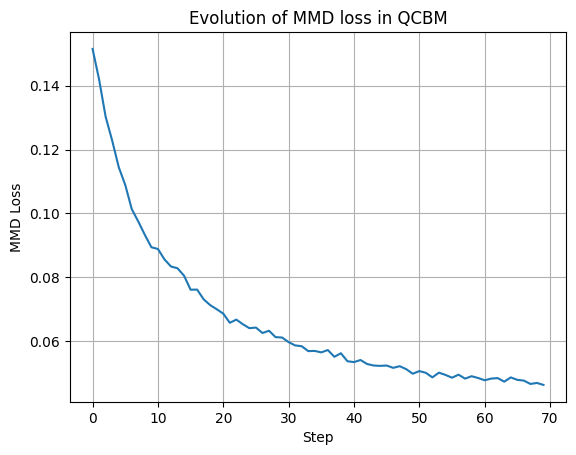

In [9]:
qcbm.plot_loss(tracking_cost)

The graph shows how the training loss is decreasing with the number of epochs, and reaches to a plateau in the end. Thus, the QCBM is learning the underlying probability distribution of the data, or more precisely, memorizing the training data.

9. Generate new samples and plot the probability distribution of the generated data

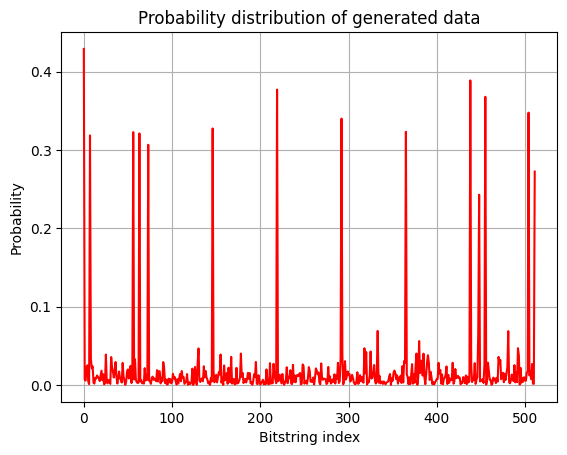

In [10]:
n_gen_samples = 200000
samples_matrix, samples = qcbm.generate_samples(n_gen_samples)
qcbm.plot_generated_distribution(samples)

We can observe how the peaks of the probability distribution resemble perfectly the training dataset, with only a bit of noise.

10. Plot some generated samples to see if they are valid

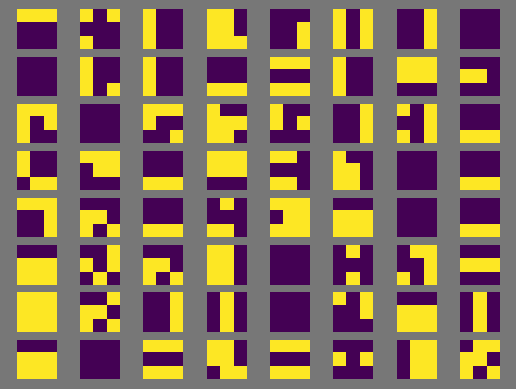

In [11]:
qcbm.plot_generated_samples(samples_matrix[0:64])

11. Calculate the generalization metrics to assess the performance of the QCBM on the bars and stripes dataset

In [12]:
x_tr = basis[target_probs > 1e-3]

metrics = qcbm.calculate_metrics(np.array(samples_matrix), x_tr, is_bs, n_sols, cost)
print("Generalization perfomance of QCBM on Bars and stripes dataset:\n", metrics)

Generalization perfomance of QCBM on Bars and stripes dataset:
 {'precision': 0.46869, 'fidelity': 0.0, 'rate': 0.0, 'coverage': 0.0, 'average cost': 1.193985}


The results show a precision value (ratio of valid generated matrices) of 0.47, which is not ideal but still showcases that the QCBM has learned decently the underlying probability distribution of the dataset. Moreover, we have obtained a very low average cost value, which indicates that most of the invalid generated matrices are invalid only due to one pixel.

Regarding the generalization capabilities, this dataset is not appropriate to study them as the number of valid elements is only 14. In order to assess the generalization, another dataset (such as the one in [7]) should be used.

### 5. References
[1] Aurélien Géron, “Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow”, O’Reilly Media, 2022.

[2] Jin-Guo Liu and Lei Wang, “Differentiable learning of quantum circuit born machines”, Physical Review A, vol. 98, no. 6, p. 062324, 2018.

[3] Andrew Alden, Blanka Horvath, and Zacharia Issa, “Signature Maximum Mean Discrepancy Two-Sample Statistical Tests”, arXiv:2506.01718, 2025.

[4] K. Mike Tao, “A closer look at the radial basis function (RBF) networks”, in *Proceedings of the 27th Asilomar Conference on Signals, Systems and Computers*, pp. 401–405, IEEE, 1993.

[5] S. Bock and M. Weiß, “A proof of local convergence for the Adam optimizer”, in *2019 International Joint Conference on Neural Networks (IJCNN)*, pp. 1–8, IEEE, 2019.

[6] C. Zhu, R. H. Byrd, P. Lu, and J. Nocedal, “Algorithm 778: L-BFGS-B: Fortran subroutines for large-scale bound-constrained optimization”, *ACM Transactions on Mathematical Software (TOMS)*, vol. 23, no. 4, pp. 550–560, 1997.

[7] K. Gili, M. Hibat-Allah, M. Mauri, C. Ballance, and A. Perdomo-Ortiz, “Do quantum circuit born machines generalize?”, *Quantum Science and Technology*, vol. 8, no. 3, p. 035021, 2023.

